# Faster R-CNN method
For this method, we will be using the Faster R-CNN methodology to detect and classify insects in images from natural agricultural environments. The Faster R-CNN method is perfect for this as it a very efficient object detection algorithm that was used to tackle the same problem from different research papers.

The Faster-RCNN method is a much improved version that builds on the original R-CNN, and the Fast R-CNN, to make it as efficient as possible.

R-CNN refers to a region based convolution neural network which worked by spliting the input image into multiple regions (region proposals). These region proposals provide insights into where an object of interest might be located by using algorithms such as selective search which iteratively segments an image based on specific image cues, rather than a pixel-by-pixel bruteforce. This already is more efficient than the bruteforce method but the selective search algorithm still generates 2000 region proposals which is quite expensive. On top of this, we individually send each region proposal to the CNN which makes it incredibly slow.

Fast R-CNN recognised these flaws and instead took the whole image and the region proposals from the selective search algorithm, and passed it as an input to the CNN to generate shared convolutional feature maps. As a result, this was significantly faster than the previous approach, however we were still limited by the bottleneck from the selective search algorithm.

Faster R-CNN fixed this by introducing the Region Proposal Network (RPN) which generates high quality regional proposals due to its convolution network nature that predicts object bounds and objectness scores at each position. This results in near cost-free region proposals where we can technically (in some cases) do real-time object detection due to how much more efficient it is.

We will be using this model since it is an industry standard and extends on the concepts taught in the lectures. It is also perfect for us since we are dealing with a huge dataset.

## Changelog

- Initial run with 10 epochs and the whole dataset ran for 1.5hrs. This resulted in ok results but zero beetles were identified.

- The issue could be the colour so I will add random colourJitter to better train my model and train it on 30 epochs now.

- Looks like changing to the SGD optimiser improved results a lot more. Now that I got some results I need to train with all images and 100 epochs. I will choose to terminate the model once I find the best loss to be more efficient.

- Looks like our object detection is pretty good but classification metrics are still not as solid as YOLO, I will add more data augmentation methods and train the whole dataset with a high patience. (we ended up improving it a lot more after this see model_v5)

- Used industry standard efficient libraries to find the most optimal hyperparams, by testing the loss against the validation dataset. This is better than a grid or random search which would take a lot of time. (advanced section)

- Since the Faster-RCNN model is trained on the COCO dataset, these include some pretty big images. However we can try and modify the anchor boxes we pass to the model by doing some data exploration on the sizes of all the training bounding boxes and adjust it based on that. (advanced section) [This ended up producing worse results. This is because the pretrained weights were already much better so it didn't make sense to improve it, see results].

- Resampled the dataset to randomly oversample or undersample on the train dataset to evaluate how our model performs (advanced)

- Adding attention maps for improved visualisation, GradCAMs helps visualise gradients in the convolution layer so we can use that. This[https://github.com/jacobgil/pytorch-grad-cam] library seems great for that, where the target layer we can use to extract the CAM from the model's backbone. (advanced)

- Added distortions to training dataset to evaluate model performance. (advanced)

In [40]:
# All the imports
import shutil
import os
import yaml
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import hashlib
from tqdm import tqdm
import fiftyone as fo
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
import torchvision.transforms as T
from pycocotools.coco import COCO
import random
from torchvision.models.detection.rpn import AnchorGenerator
import optuna
import optuna.visualization as vis
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import numpy as np
from sklearn.metrics import roc_auc_score
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget

In [ ]:
# Download the dataset from kaggle and specify the path here
path = r"C:\Users\arjun\.cache\kagglehub\datasets\rupankarmajumdar\crop-pests-dataset\versions\2"

In [53]:
new_dataset_location = Path('./content/crop_pests_dataset')

if not new_dataset_location.exists():
  # Copy the kaggle dataset to our codebase
  current_dataset_path = Path(path)
  shutil.copytree(current_dataset_path, new_dataset_location)

  data_yaml = new_dataset_location / 'dataset.yaml'
  
  # Convert data.yaml to dataset.yml to meet YOLOv5 naming conventions
  if ((new_dataset_location / "data.yaml").exists()):
    shutil.move(new_dataset_location / 'data.yaml', data_yaml)
  
  # Update contents of dataset.yaml to be in the correct format
  with open(data_yaml, 'r') as f:
    data = yaml.safe_load(f)
  
  # Run manipulations to make correct format
  if 'train' in data and data['train'] == '../train/images':
    data['train'] = './train/images'
  if 'val' in data and data['val'] == '../valid/images':
    data['val'] = './valid/images'
  if 'test' in data and data['test'] == '../test/images':
    data['test'] = './test/images'
  
  # Write the updated data back to the file
  with open(data_yaml, 'w') as f:
    yaml.dump(data, f)
  
  print(f"Dataset successfully moved to: {new_dataset_location}")
else:
  data_yaml = new_dataset_location / 'dataset.yaml'

train_img_dir = new_dataset_location / "train" / "images"
train_lab_dir = new_dataset_location / "train" / "labels"


In [54]:
# Extract the classnames from the data.yaml file
classnames = None

if data_yaml.exists():
  with open(data_yaml) as f:
    data = yaml.safe_load(f)

  if 'names' in data:
    classnames = data['names']

print("Number of classes: " + str(len(classnames)))
print(classnames)


Number of classes: 12
['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


## Data Exploration and Preprocessing 
The following section has most of the preprocessing steps and minor Faster-RCNN specific data exploration before training the model. Some of the preprocessing steps include:
- Removing duplicate images by computing the hash
- Converting our initial YOLO formatted dataset to the COCO format our model uses
- Plotting some images with their bounding boxes to test our dataset
- Applying data augmentation techniques to random images in our dataset such as increasing/decreasing brightness, random rotations, blurs etc.
- Getting the stats of the bounding boxes to tweak the anchor boxes of the Faster R-CNN model

In [4]:
# Removing duplicate files as we found by copying code from data exploration
# section
def hash_image(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
dups = []

for f in tqdm(os.listdir(train_img_dir), desc="Hashing images"):
    h = hash_image(os.path.join(train_img_dir, f))
    if h in hashes:
        dups.append((f, hashes[h]))
    else:
        hashes[h] = f

print(f"\nPotential duplicate pairs found: {len(dups)}")

for f1, f2 in dups:
    path = os.path.join(train_img_dir, f2)
    if os.path.exists(path):
        os.remove(path)
        print("Removed:", f2)

Hashing images: 100%|██████████| 11499/11499 [00:02<00:00, 5164.65it/s]


Potential duplicate pairs found: 0


In [ ]:
def create_export_yolo_dataset(path, export_dir):

  splits = ["test", "train", "val"]
  output_paths = {}

  for split in splits:
    # Create the fiftyone dataset in YOLO format
    dataset = fo.Dataset.from_dir(
      dataset_dir=str(path),
      dataset_type=fo.types.YOLOv5Dataset,
      split=split,
      name=f"Insects_YOLO_{split}_dataset",
      overwrite=True
    )

    output_dir = export_dir / split
    output_dir.mkdir(exist_ok=True, parents=True)

    dataset.export(
        export_dir=str(output_dir),
        dataset_type=fo.types.COCODetectionDataset,
        label_field="ground_truth",
        overwrite=True
    )

    output_paths[split] = output_dir

    # Clean up
    dataset.delete()

  return output_paths

coco_dataset_path = create_export_yolo_dataset(new_dataset_location, Path("./content/crop_pests_dataset_coco"))
print(coco_dataset_path)


c:\Users\arjun\Desktop\Computer-Vision\assignment\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 100% |█████████████████| 546/546 [977.4ms elapsed, 0s remaining, 558.6 samples/s]      
 100% |█████████████████| 546/546 [1.1s elapsed, 0s remaining, 513.2 samples/s]         
 100% |█████████████| 11499/11499 [13.3s elapsed, 0s remaining, 923.8 samples/s]      
 100% |█████████████| 11499/11499 [22.1s elapsed, 0s remaining, 529.4 samples/s]      
 100% |███████████████| 1095/1095 [1.2s elapsed, 0s remaining, 893.9 samples/s]         
 100% |███████████████| 1095/1095 [2.0s elapsed, 0s remaining, 554.6 samples/s]      
{'test': WindowsPath('content/crop_pests_dataset_coco/test'), 'train': WindowsPath('content/crop_pests_dataset_coco/train'), 'val': WindowsPath('content/crop_pests_dataset_coco/val')}


content\crop_pests_dataset_coco\train\data
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
content\crop_pests_dataset_coco\train\data\moth-431-_jpg.rf.fa9543d16803aca88cc91ecd7da41ede.jpg


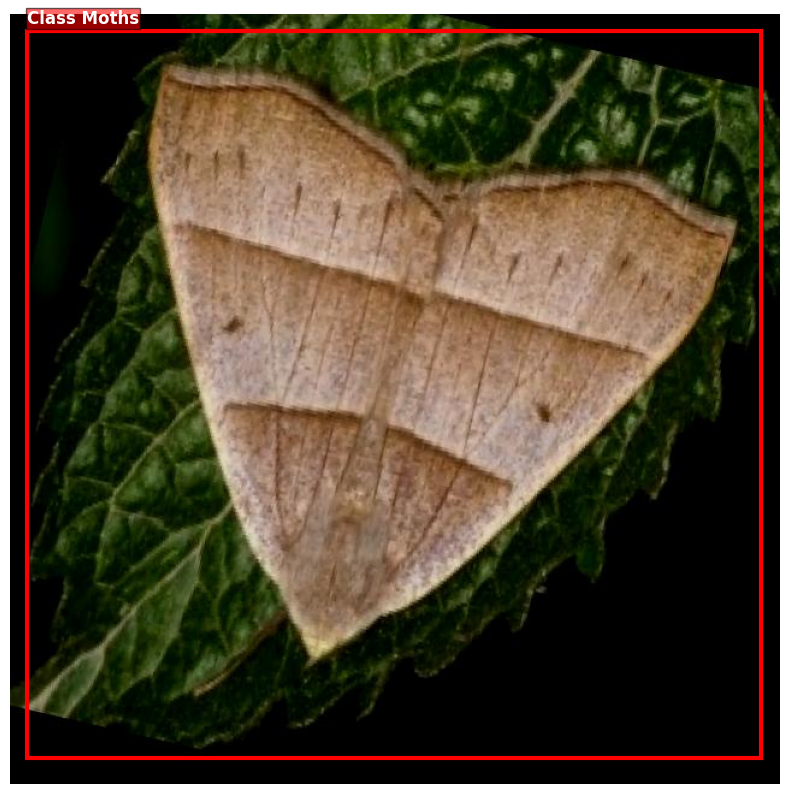

content\crop_pests_dataset_coco\train\data\snail-493-_jpg.rf.633aec943e96f8a9c802ff8db6290ab4.jpg


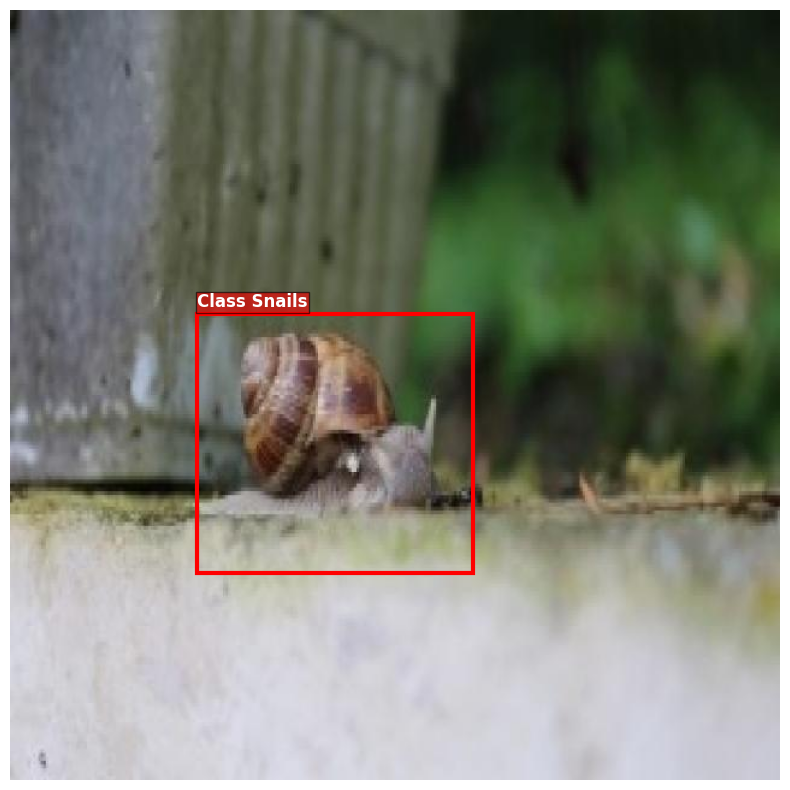

content\crop_pests_dataset_coco\train\data\ants-489-_jpg.rf.9f224527df298feb351368b93ae774fa.jpg


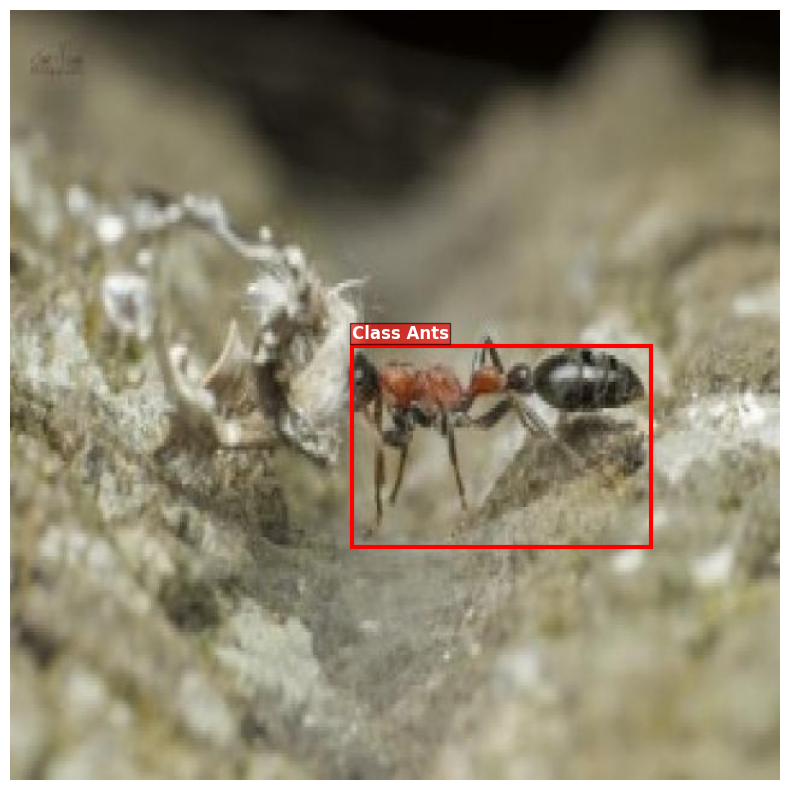

In [85]:
# Check to see if the coco dataset we converted to has the correct bounding boxes
def plot_random_COCO_images(label_file, images, n=5):
  print(str(images))
  coco = COCO(str(label_file))
  image_ids = coco.getImgIds()
  samples = random.sample(image_ids, n)

  for id in samples:
    image_path = images / str(coco.loadImgs(id)[0]['file_name'])
    print(str(image_path))
    image = Image.open(str(image_path)).convert("RGB")

    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)

    annotations = coco.loadAnns(coco.getAnnIds(imgIds=id))

    for annotation in annotations:
      x, y, w, h = annotation['bbox']
      bounding_box = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='red', facecolor='none')
      ax.add_patch(bounding_box)

      class_of_interest = classnames[annotation['category_id'] - 1]
      ax.text(x, y - 6, f"Class {class_of_interest}",
                            color="white", fontsize=12, weight="bold",
                            bbox=dict(facecolor='red', alpha=0.6, pad=1))
    plt.axis('off')
    plt.show()

plot_random_COCO_images(Path('content/crop_pests_dataset_coco/train') / 'labels.json', Path('content/crop_pests_dataset_coco/train') / 'data', n=3)

In [77]:
# Creating specific transformations to simulate data augmentation that will allow our model to
# make better predictions. https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
# We will also need to convert our PIL images to tensors.
transforms = T.Compose([
    T.ToTensor(),
    # Rotate our images 15 degrees to make model more robust
    T.RandomRotation(15),
    # +-30% brightness and +-10% hue
    T.ColorJitter(
        brightness=0.3,
        hue=0.1
    ),
    T.RandomHorizontalFlip(p=0.3),
    # This is to blur the images randomly, this will be
    # useful for the advanced section of marks.
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
# The following class will add gausian noise to our images by defining a custom transform
class AddGausianianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.std = std
    self.mean = mean
        
  def __call__(self, tensor):
    return tensor + torch.randn(tensor.size()) * self.std + self.mean
  
  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

val_transforms = T.Compose([
    T.ToTensor()
])

distortion_transforms = T.Compose([
    T.ToTensor(),
    # Add gaussian noise with 50% prob
    T.RandomApply([AddGausianianNoise(0., 0.1)], p=0.5),
    # Adjust brightness of images with 50% prob
    T.RandomApply([T.ColorJitter(
        brightness=0.5
    )], p=0.5)
])

# Preparing the dataset. We already have our dataset converted from YOLO to COCO
# so that is good. However, we still need to inform our Faster R-CNN model of the
# exact bonding boxes and their corresponding labels.
# To better understand why read the top markdown to get a
# sense of how this model actually works.
class PestsDataset(Dataset):
  def __init__(self, transforms, coco_labels_file, image_dir, max_images=None, random_sample=True, seed=42, is_imbalanced=False):
    self.transforms = transforms
    # COCO files are formatted a bit different https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/md-coco-overview.html
    # Go ahead and use the cocoapi to extract the important parts.
    self.data = COCO(coco_labels_file)
    self.images = Path(image_dir)

    # Some ids don't have annotations, handle them accordingly since
    # faster R-CNN doesn't support this!
    self.ids = []
    num_skipped = 0
    for id in sorted(self.data.imgs.keys()):
      annotation_id = self.data.getAnnIds(imgIds=id)

      if len(annotation_id) > 0:
        self.ids.append(id)
      else:
        num_skipped += 1

    print(f"Skipped {num_skipped} annotations!")

    # The following code will artifically imbalance the dataset of interest.
    # This is mainly to test how well our model can handle imbalanced datasets
    # for the advanced section of marks.
    if is_imbalanced is not False:
      self.ids = self.__imbalance_dataset(seed)

    # Used for development to set a hard limit of samples
    if max_images is not None and len(self.ids) > max_images:
      random.seed(seed)
      self.ids = random.sample(self.ids, max_images)
      print(f"We have reduced dataset to {len(self.ids)}")

  def __len__(self):
    return len(self.ids)
  
  def __imbalance_dataset(self, seed):
    random.seed(seed)

    class_ids = {}
    for id in self.ids:
      annotations = self.data.loadAnns(self.data.getAnnIds(imgIds=id))

      for annotation in annotations:
        if annotation['category_id'] not in class_ids:
          class_ids[annotation['category_id']] = []
        class_ids[annotation['category_id']].append(id)

    # Now randomly drop or add samples from certain classes
    # to simulate imbalance
    imbalanced_ids = []
    new_class_distribution = {}
    original_class_cnts = {}
    new_class_cnts = {}
    for class_id, ids in class_ids.items():
      ratio = random.uniform(0.05, 2.5)

      original_class_cnts[class_id] = len(ids)
      new_class_distribution[class_id] = ratio
      
      if ratio < 1.0:
        # Go ahead and undersample the original ids based on each class
        sampled_ids = random.sample(ids, int(len(ids) * ratio))
      else:
        # Oversample the dataset
        sampled_ids = random.choices(ids, k=int(len(ids) * ratio))

      imbalanced_ids.extend(sampled_ids)
      new_class_cnts[class_id] = len(sampled_ids)

    print("Original class distribution:\n")
    for class_id, count in original_class_cnts.items():
      print(f"{classnames[class_id - 1]}: {count}")

    print("\nNew class distribution:\n")
    for class_id, count in new_class_cnts.items():
      print(f"{classnames[class_id - 1]}: {count}")

    print(f"Num original images: {len(self.ids)}\tNum new images: {len(imbalanced_ids)}")

    return list(imbalanced_ids)
  

  def __getitem__(self, idx):
    # Load image
    img = Image.open(self.images / self.data.loadImgs(self.ids[idx])[0]['file_name']).convert("RGB")

    # Load annotations
    annotation_ids = self.data.getAnnIds(imgIds=self.ids[idx])
    annotations = self.data.loadAnns(annotation_ids)

    # Load in Boxes, Labels, Area and Crowds (https://github.com/ppwwyyxx/cocoapi/blob/master/PythonAPI/pycocotools/coco.py)
    labels = []
    boxes = []
    iscrowds = []
    areas = []

    for annotation in annotations:
      x, y, w, h = annotation['bbox']
      labels.append(annotation['category_id'])
      # x_min, y_min, x_max, y_max
      boxes.append([x, y, x + w, y + h])
      # If 0 then dealing with single object, if 1 then more
      iscrowds.append(annotation.get('iscrowd', 0))

    # Build target object
    target = {}

    # Convert lists to tensors to train with
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["iscrowds"] = torch.as_tensor(iscrowds, dtype=torch.int64)
    target["areas"] = torch.as_tensor(areas, dtype=torch.float32)
    target["imageId"] = torch.as_tensor([self.ids[idx]])

    # Apply the transformations
    if self.transforms is not None:
      img = self.transforms(img)

    return img, target

base_path = Path("./content/crop_pests_dataset_coco")
training_dataset = PestsDataset(transforms=transforms, coco_labels_file=base_path / "train" / "labels.json", image_dir=base_path / "train" / "data", max_images=5000)
test_dataset = PestsDataset(transforms=val_transforms, coco_labels_file=base_path / "test" / "labels.json", image_dir=base_path / "test" / "data")
val_dataset = PestsDataset(transforms=val_transforms, coco_labels_file=base_path / "val" / "labels.json", image_dir=base_path / "val" / "data")

test_imbalanced_dataset = PestsDataset(transforms=val_transforms, coco_labels_file=base_path / "test" / "labels.json", image_dir=base_path / "test" / "data", is_imbalanced=True)
test_distorted_dataset = PestsDataset(transforms=distortion_transforms, coco_labels_file=base_path / "test" / "labels.json", image_dir=base_path / "test" / "data")
print(f"Train Dataset len = {len(training_dataset)}")
print(f"Test Dataset len = {len(test_dataset)}")
print(f"Val Dataset len = {len(val_dataset)}")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Skipped 3 annotations!
We have reduced dataset to 5000
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Skipped 0 annotations!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Skipped 0 annotations!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Skipped 0 annotations!
Original class distribution:

Weevils: 58
Ants: 87
Beetles: 44
Bees: 44
Caterpillars: 93
Moths: 47
Earthworms: 40
Earwigs: 73
Grasshoppers: 55
Slugs: 51
Snails: 50
Wasps: 47

New class distribution:

Weevils: 93
Ants: 17
Beetles: 105
Bees: 109
Caterpillars: 172
Moths: 56
Earthworms: 60
Earwigs: 137
Grasshoppers: 135
Slugs: 82
Snails: 113
Wasps: 78
Num original images: 546	Num new images: 1157
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Skipped 0 annotations!
Train Dataset len = 5000
Test Dataset len 

In [12]:
# The purpose of this section is to get an idea of the
# sizes of the bounding boxes in our dataset so that we can
# adjust the anchor boxes of the faster RCNN model based
# on our data. This is because maybe the default ones are too
# big.
def analyse_bounding_boxes(dataset):
  heights = []
  widths = []
  ratios = []
  box_areas = []

  for idx in tqdm(range(len(dataset)), desc="Checking bounding boxes"):
    _, target = dataset[idx]
    boxes = target['boxes']

    for box in boxes:
      x_min, y_min, x_max, y_max = box
      height = y_max - y_min
      width = x_max - x_min

      heights.append(height)
      widths.append(width)
      ratios.append(width / height if height != 0 else 0)
      box_areas.append(height * width)

  print("Bounding Box Analysis:")
  print(f"Min Height: {min(heights):.3f}\tMax Height: {max(heights):.3f}\tAvg Height: {sum(heights)/len(heights):.3f}")
  print(f"Min Width: {min(widths):.3f}\tMax Width: {max(widths):.3f}\tAvg Width: {sum(widths)/len(widths):.3f}")
  print(f"Min Ratio: {min(ratios):.3f}\tMax Ratio: {max(ratios):.3f}\tAvg Ratio: {sum(ratios)/len(ratios):.3f}")
  print(f"Min Area: {min(box_areas):.3f}\tMax Area: {max(box_areas):.3f}\tAvg Area: {sum(box_areas)/len(box_areas):.3f}")
    

analyse_bounding_boxes(training_dataset)
      

Checking bounding boxes: 100%|██████████| 5000/5000 [03:27<00:00, 24.13it/s]


Bounding Box Analysis:
Min Height: 1.000	Max Height: 640.000	Avg Height: 337.791
Min Width: 2.000	Max Width: 640.000	Avg Width: 323.686
Min Ratio: 0.068	Max Ratio: 14.000	Avg Ratio: 0.982
Min Area: 11.250	Max Area: 409600.000	Avg Area: 135187.781


## Training the Faster-RCNN model
This is where we train the Faster R-CNN model and make incremental adjustments in order to make our model perform better. We are using the Faster-RCNN model with the Resnet50 backbone using pretrained weights initially. This is because not using pretrained weights are taking too long to run. We also ran the model on the validation set, where programatically we found the best possible hyperparameters which would reduce the loss the most. We aimed to train the model on 100 epochs with a patience of 5, where after 5 iterations if the models loss wasn't improving, we would terminate it and use the best model we found. This was usually around the 30 epoch mark. Most adjustments I made can be found in the Changelog section of the first markdown.

In [58]:
# Since the following section will be pretty intensive, we might want to consider using the GPU if available.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# From the results of the bounding box analysis we can see that
# we have both extremely small and large bounding boxes. So we can
# modify the anchor boxes a bit and see if thats improving our model.
# The default is given here: https://github.com/pytorch/vision/blob/96aa3d928c6faaf39defd846966421679244412d/torchvision/models/detection/faster_rcnn.py#L37-L40
custom_anchor_gen = AnchorGenerator(
  sizes=((8, 32, 128, 256, 512),) * 5,
  aspect_ratios=((0.05, 0.5, 1.0, 2.0, 15.0),) * 5
)

In [ ]:
# Taking inspiration from https://medium.com/@RobuRishabh/understanding-and-implementing-faster-r-cnn-248f7b25ff96
# to setup the basics before tweaking it further to be more original

# Configure the pretrained model parameters and which model to use
# We will be using faster R-CNN with the resnet 50 convolutional neural network
model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True)

# We will have 13 classes, 12 classes + background. Can calculate this programatically
# but since we did some data exploration we know this.
num_classes = len(training_dataset.data.getCatIds()) + 1
print(num_classes)

# Number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features

# https://docs.pytorch.org/vision/0.12/_modules/torchvision/models/detection/faster_rcnn.html
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Display the model architecture
model

c:\Users\arjun\Desktop\Computer-Vision\assignment\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arjun\Desktop\Computer-Vision\assignment\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


13


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [72]:
# Setup the data loaders
train_loader = DataLoader(training_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# DataLoaders for the advanced section
imbalanced_test_loader = DataLoader(test_imbalanced_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
distorted_test_loader = DataLoader(test_distorted_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Testing the hyperparameters. We can do this programatically
# using many configurations and carrying out a grid search or random search but according
# to research, optuna is the industry standard for hyperparameter tuning
# due to how efficient it is. We will be using it to our advantage. After
# running the search it is definitely clear the params we found improved our
# models performance a lot!

# Setting these to small values to find the best hyperparameters quickly
training_dataset_small = PestsDataset(transforms=transforms, coco_labels_file=base_path / "train" / "labels.json", image_dir=base_path / "train" / "data", max_images=500)
val_dataset_small = PestsDataset(transforms=val_transforms, coco_labels_file=base_path / "val" / "labels.json", image_dir=base_path / "val" / "data", max_images=100)

def objective_fc(trial):
  # Learning rate refers to how much the weigths are updated during training
  # to min the error. Low =  slower updates, High = faster updates
  lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

  # Momentum is usually recommended within the 0.9 value so
  # we will experiment within that range
  momentum = trial.suggest_float('momentum', 0.8, 0.9)

  # Helps prevent overfitting by adding a small penalty to large weights
  weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

  # Num epochs before lr is reduced
  step_size = trial.suggest_int('step_size', 2, 5)

  # Gamma is the factor by which the lr is decayed
  gamma = trial.suggest_float('gamma', 0.1, 0.3)

  batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])

  trial_train_loader = DataLoader(training_dataset_small, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
  trial_val_loader = DataLoader(val_dataset_small, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

  # Prepare a new model for each trial
  model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  model.to(device)

  # Setup the optimiser and lr scheduler using our new hyperparameters
  params = [p for p in model.parameters() if p.requires_grad]
  optimiser = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=step_size, gamma=gamma)

  num_epochs = 8
  best_loss = float('inf')
  for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for images, targets in trial_train_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      # Zeroing the gradients
      optimiser.zero_grad()

      # Forward pass
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())

      # Backward Pass
      losses.backward()
      optimiser.step()

      train_loss += losses.item()
    
    # Validation phase
    model.train()
    validation_loss = 0.0
    with torch.no_grad():
      for val_images, val_targets in trial_val_loader:
        val_images = list(image.to(device) for image in val_images)
        val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

        val_loss_dict = model(val_images, val_targets)
        val_losses = sum(loss for loss in val_loss_dict.values())

        validation_loss += val_losses.item()
    
    avg_validation_loss = validation_loss / len(trial_val_loader)
    best_loss = min(best_loss, avg_validation_loss)

    lr_scheduler.step()

    trial.report(avg_validation_loss, epoch)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return best_loss
  
# Setting up optuna based on this guide
# https://medium.com/data-and-beyond/master-the-power-of-optuna-a-step-by-step-guide-ed43500e9b95
# We will also setup a pruner for early stoppage of poor trials, this will be more efficient.
# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html
study = optuna.create_study(
  direction='minimize',
  pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

study.optimize(objective_fc, n_trials=100, timeout=2*60*60)
best_trial = study.best_trial

print(f"Best trial validation loss: " + str(best_trial.value))
print("Best hyperparameters: " + str(best_trial.params))

vis.plot_optimization_history(study)
plt.show()

vis.plot_param_importances(study)
plt.show()

vis.plot_slice(study)
plt.show()

[I 2025-11-15 11:35:13,887] A new study created in memory with name: no-name-b3529b16-8a84-4332-8402-d41c657e3b31


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Skipped 3 annotations!
We have reduced dataset to 500
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Skipped 0 annotations!
We have reduced dataset to 100
Using device: cuda


[I 2025-11-15 11:36:14,954] Trial 0 finished with value: 0.3685276691730206 and parameters: {'lr': 0.0007014193377898545, 'momentum': 0.8129233930895721, 'weight_decay': 0.0005182209779786103, 'step_size': 5, 'gamma': 0.25137890204454705, 'batch_size': 8}. Best is trial 0 with value: 0.3685276691730206.
[I 2025-11-15 11:37:15,873] Trial 1 finished with value: 0.32157524617818684 and parameters: {'lr': 0.005045578819686325, 'momentum': 0.8392077312703774, 'weight_decay': 0.00024409954441106984, 'step_size': 3, 'gamma': 0.22384615170305927, 'batch_size': 8}. Best is trial 1 with value: 0.32157524617818684.
[I 2025-11-15 11:38:22,715] Trial 2 finished with value: 0.37371569633483886 and parameters: {'lr': 0.00045347242529817126, 'momentum': 0.8111842572317985, 'weight_decay': 0.000335421999180504, 'step_size': 3, 'gamma': 0.13394054211100756, 'batch_size': 2}. Best is trial 1 with value: 0.32157524617818684.
[I 2025-11-15 11:39:26,890] Trial 3 finished with value: 0.33795585453510285 and 

Best trial validation loss: 0.29629021406173706
Best hyperparameters: {'lr': 0.009545592965947251, 'momentum': 0.821481641081652, 'weight_decay': 4.677198162075667e-05, 'step_size': 4, 'gamma': 0.21626022971723102, 'batch_size': 2}


In [ ]:
# In the event that the kernel dies, this variable can be changed to
# "FAILED" to resume training from the last best checkpoint. This has
# been extremely helpful since R-CNN models take too long to train.
RUN_STATUS = "SUCCESS"

if RUN_STATUS != "SUCCESS":
  # TODO: Change this to the desired model checkpoint you want to use
  model_of_interest = './models/best_model_v5.pt'
  checkpoint = torch.load(model_of_interest, map_location=device)

  # Load the model as normal, but we will be loading the saved
  # weights from the checkpoint.
  model = fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, checkpoint['num_classes'])
  model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

# Setup the optimiser, learning rate scheduler and begin training the model
params = [p for p in model.parameters() if p.requires_grad]

# We will be using the SGD optimiser since it works well
# https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html
optimiser = torch.optim.SGD(params, lr=0.009545592965947251, momentum=0.821481641081652, weight_decay=4.677198162075667e-05)

failed_start_epoch = 0
if RUN_STATUS != "SUCCESS":
  # We also need to load the optimisers state dict since pytorch
  # requires it. We can also extract the epoch it failed from and resume
  # from there.
  optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
  failed_start_epoch = checkpoint['epoch'] + 1
  print(f"Resuming training from epoch {failed_start_epoch}")

# Set up Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimiser, step_size=4, gamma=0.21626022971723102)

# Training the model
num_epochs = 100
patience = 5
best_loss = float('inf') if RUN_STATUS == "SUCCESS" else checkpoint['train_loss']
num_runs = 0
total_runtime = 0
for epoch in range(failed_start_epoch, num_epochs):
  start_time = time.time()

  model.train()
  train_loss = 0.0

  for images, targets in train_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Zeroing the gradients
    optimiser.zero_grad()

    # Forward pass
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    # Backward Pass
    losses.backward()
    optimiser.step()

    train_loss += losses.item()

  avg_train_loss = train_loss / len(train_loader)

  lr_scheduler.step()

  time_to_run_epoch = time.time() - start_time
  total_runtime += time_to_run_epoch
  print(f'Epoch: {epoch + 1}, Training Loss: {avg_train_loss}, Time: {time_to_run_epoch / 60:.2f}mins')

  # Check if we should stop based on our patience and
  # loss
  if avg_train_loss < best_loss:
    best_loss = avg_train_loss
    num_runs = 0

    # Keep saving our best learned model so that we are efficient
    # WARNING: This will overwrite the previous best model so be careful
    # with what you name it to!
    new_checkpoint_path = './models/best_model_v6_pretrained.pt'
    torch.save({
      "epoch": epoch,
      "model_state_dict": model.state_dict(),
      "optimiser_state_dict": optimiser.state_dict(),
      "num_classes": num_classes,
      "classnames": classnames,
      "train_loss": best_loss
    }, new_checkpoint_path)

    print(f"Saving best model with a training loss of {best_loss:.5f}")
  else:
    # We have not found the best model so increase our patience
    num_runs += 1
    print(f"Increasing count to ${num_runs}")

    # We have run out of patience and must exit since there is no improvement :(
    if num_runs >= patience:
      print(f"Stopping training at {epoch + 1} epoches since model wasn't improving.")
      break

print(f'Finished running model! It took {total_runtime / 60:.2f} minutes to run {epoch + 1} epochs.')



Using device: cuda
Epoch: 1, Training Loss: 0.2559629167050123, Time: 11.46mins
Saving best model with a training loss of 0.25596
Epoch: 2, Training Loss: 0.2330228230550885, Time: 11.40mins
Saving best model with a training loss of 0.23302
Epoch: 3, Training Loss: 0.21796327745616437, Time: 11.76mins
Saving best model with a training loss of 0.21796
Epoch: 4, Training Loss: 0.20819535267800093, Time: 12.23mins
Saving best model with a training loss of 0.20820
Epoch: 5, Training Loss: 0.17903812707960606, Time: 12.20mins
Saving best model with a training loss of 0.17904
Epoch: 6, Training Loss: 0.17150746838524938, Time: 12.24mins
Saving best model with a training loss of 0.17151
Epoch: 7, Training Loss: 0.16815437057167293, Time: 12.26mins
Saving best model with a training loss of 0.16815
Epoch: 8, Training Loss: 0.16381577606126665, Time: 12.24mins
Saving best model with a training loss of 0.16382
Epoch: 9, Training Loss: 0.15768308715745807, Time: 12.27mins
Saving best model with a 

In [78]:
def use_saved_model(model_path):
  """The following method will load a previously saved model checkpoint based on the specified path, load the necessary 
  state dictionaries and return the model for us to use. This is very useful during the inference stage."""
  saved_model = torch.load(model_path, map_location=device)

  # Not going to choose pretrained this time since we our supplying
  # our previously ran version
  new_model = fasterrcnn_resnet50_fpn(pretrained=False)

  input_features = new_model.roi_heads.box_predictor.cls_score.in_features
  num_classes = saved_model.get("num_classes")
  classnames = saved_model.get("classnames")

  new_model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)

  new_model.load_state_dict(saved_model["model_state_dict"])
  new_model.to(device)
  return new_model

# TODO: UNCOMMENT THIS OUT WHEN YOU NEED TO
model = use_saved_model(str('./models/best_model_v5.pt'))

c:\Users\arjun\Desktop\Computer-Vision\assignment\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arjun\Desktop\Computer-Vision\assignment\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Inference and Evaluation
In the following section we will build the code to test out how our model is performing with our training dataset. We will also build the metrics listed in the specification which gives us a good baseline on the performance of our model during object detection and classification. We also display the ground truths of some images against what our model predicted to get an indicator of how well it is doing. We also build attention maps in order to get an idea on what pixels our model is focusing on. All these will contribute in helping us compare the different methods we implemented in this assignment.

In [81]:
# We will be using MAP for detecting how good the model is
# for object detection
metric = MeanAveragePrecision()

# We will be using precision, recall, F1 score,
# accuracy, and the area under the curve (AUC) to determine classification
# performance
y_true, y_pred, y_score = [], [], []
iou_threshold = 0.5

# Evaluating the time the model takes to run the inference
start_time = time.time()
model.eval()
with torch.no_grad():
  for images, targets in test_loader:
    images = [img.to(device) for img in images]
    predictions = model(images)

    predictions = [{k: v.to('cpu') for k, v in o.items()} for o in predictions]
    targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]

    # Filter out predictions below a certain confidence threshold
    # this is because our model will output a lot of low confidence
    # predictions which will skew our results. We want to use the things
    # it is reasonably confident about. The higher the threshold the 
    # the more false positives will drop but false negatives increase.
    # In our case 0.5 is more balanced but false negatives are more damaging
    # to the problem we are solving so maybe we can lower it a bit.
    confidence_threshold = 0.5
    filtered_predictions = []
    for pred in predictions:
        filtered_predictions.append({
            'labels': pred['labels'][pred['scores'] >= confidence_threshold],
            'boxes': pred['boxes'][pred['scores'] >= confidence_threshold],
            'scores': pred['scores'][pred['scores'] >= confidence_threshold]
        })

    metric.update(filtered_predictions, targets)

    for pred_output, pred_target in zip(filtered_predictions, targets):
      pred_labels = pred_output["labels"].numpy()
      true_labels = pred_target["labels"].numpy()
      pred_boxes = pred_output["boxes"].numpy()
      true_boxes = pred_target["boxes"].numpy()
      pred_scores = pred_output["scores"].numpy()

      # We need to skip if don't have prediction and truth boxes
      if len(pred_boxes) == 0 and len(true_boxes) == 0:
        continue

      # If we don't have truth boxes then all the predictions are
      # false positives
      if len(true_boxes) == 0:
        for pred_idx in range(len(pred_labels)):
          y_true.append(-1)
          y_pred.append(pred_labels[pred_idx].item())
          y_score.append(pred_scores[pred_idx].item())
        continue

      # If we don't have prediction boxes then all the truth boxes are
      # false negatives
      if len(pred_boxes) == 0:
        for true_idx in range(len(true_labels)):
          y_true.append(true_labels[true_idx].item())
          y_pred.append(-1)
          y_score.append(0.0)
        continue

      # This will compute the intersection-over-union between
      # the boxes we predicted verses the true boxes.
      ious = torchvision.ops.box_iou(torch.from_numpy(pred_boxes), torch.from_numpy(true_boxes))

      # For each prediction find the best true and pred box match.
      # We make sure to only assign one true box to only one pred box.
      best_true_box = set()
      best_pred_box = set()
      for pred_idx, pred_box in enumerate(pred_boxes):
        max_iou, true_idx = torch.max(ious[pred_idx], dim=0)

        if max_iou >= iou_threshold and true_idx.item() not in best_true_box:
          # True positive case
          best_true_box.add(true_idx.item())
          best_pred_box.add(pred_idx)

          y_pred.append(pred_labels[pred_idx].item())
          y_true.append(true_labels[true_idx].item())
          y_score.append(pred_scores[pred_idx].item())
        else:
          # False positive case
          best_pred_box.add(pred_idx)

          y_pred.append(pred_labels[pred_idx].item())
          y_score.append(pred_scores[pred_idx].item())
          y_true.append(-1)

      for true_idx in range(len(true_boxes)):
        if true_idx not in best_true_box:
          # False negative case
          y_true.append(true_labels[true_idx].item())
          y_pred.append(-1)
          y_score.append(0.0)

eval_time = time.time() - start_time
if eval_time < 60:
  print(f"Evaluation took {eval_time:.2f} seconds")
else:
  print(f"Evaluation took {eval_time / 60:.2f} minutes")

# Object detection metric
# Faster R-CNN seems to be having a pretty reasonable mAP score
# which means its detecting the objects well.
mAP_res = metric.compute()
print(f"mAP@0.5: {mAP_res['map_50']:.4f}")
print(f"mAP@[0.5:0.95]: {mAP_res['map']:.4f}")

# Classification metric
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

print(f"Num ground truths = {np.sum(y_true != -1)}")

# Count the True Positives, False Positives, and False Negatives per class
tp_by_class = {}
fp_by_class = {}
fn_by_class = {}

# Go through the predictions and ground truths and extract the
# TP, FP, FN counts
for true_label, pred_label in zip(y_true, y_pred):
    if true_label == pred_label and true_label != -1: # True Positive case
        tp_by_class[true_label] = tp_by_class.get(true_label, 0) + 1
    elif pred_label != -1 and true_label != pred_label: # False Positive case
        fp_by_class[pred_label] = fp_by_class.get(pred_label, 0) + 1
    elif true_label != -1 and pred_label == -1: # False Negative case
        fn_by_class[true_label] = fn_by_class.get(true_label, 0) + 1

# Calculate overall metrics manually using
# https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall,
# apparently sklearn's metrics don't do well with image classification tasks.
total_tp = sum(tp_by_class.values())
total_fp = sum(fp_by_class.values())
total_fn = sum(fn_by_class.values())

precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
accuracy = total_tp / (total_tp + total_fp + total_fn) if (total_tp + total_fp + total_fn) > 0 else 0.0

print(f"Total True Positives: {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")

print(f"Overall Accuracy: {accuracy:.5f}")
print(f"Overall Precision: {precision:.5f}")
print(f"Overall Recall: {recall:.5f}")
print(f"Overall F1 Score: {f1:.5f}")

# Get per class metrics
# Not all classes will have TP, FP, FN so we need to programatically get the class_ids
# of interest.
unique_classes = sorted(set(list(tp_by_class.keys()) + list(fp_by_class.keys()) + list(fn_by_class.keys())))
print(f"\nClassification Metrics based on each class:")
for class_id in unique_classes:
    tp = tp_by_class.get(class_id, 0)
    fp = fp_by_class.get(class_id, 0)
    fn = fn_by_class.get(class_id, 0)
    
    class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0.0
    
    print(f"{classnames[class_id - 1]}: Precision={class_precision:.4f}\tRecall={class_recall:.4f}\tF1={class_f1:.4f}")

# We will be using a One v Rest approach to calculate this as its
# the simplist for our case.
print(f"\nAUC based on each class:")
for cls in range(1, num_classes):
  y_true_binary = (y_true == cls).astype(int)
  y_score_binary = []

  for score, pred in zip(y_score, y_pred):
    if pred == cls:
      y_score_binary.append(score)
    else:
      y_score_binary.append(0.0)

  auc = roc_auc_score(y_true_binary, y_score_binary)
  print(f"Class {classnames[cls - 1]} ({cls}) with AUC: {auc:.4f}")

Evaluation took 25.36 seconds
mAP@0.5: 0.7251
mAP@[0.5:0.95]: 0.4110
Num ground truths = 689
Total True Positives: 505
Total False Positives: 233
Total False Negatives: 148
Overall Accuracy: 0.56998
Overall Precision: 0.68428
Overall Recall: 0.77335
Overall F1 Score: 0.72610

Classification Metrics based on each class:
Ants: Precision=0.7011	Recall=0.7531	F1=0.7262
Bees: Precision=0.7755	Recall=0.9048	F1=0.8352
Beetles: Precision=0.6585	Recall=0.7297	F1=0.6923
Caterpillars: Precision=0.5422	Recall=0.5056	F1=0.5233
Earthworms: Precision=0.3478	Recall=0.6486	F1=0.4528
Earwigs: Precision=0.6265	Recall=0.7429	F1=0.6797
Grasshoppers: Precision=0.6667	Recall=0.6275	F1=0.6465
Moths: Precision=0.9375	Recall=1.0000	F1=0.9677
Slugs: Precision=0.6792	Recall=0.7200	F1=0.6990
Snails: Precision=0.7857	Recall=0.8980	F1=0.8381
Wasps: Precision=0.7797	Recall=0.9787	F1=0.8679
Weevils: Precision=0.8871	Recall=1.0000	F1=0.9402

AUC based on each class:
Class Ants (1) with AUC: 0.8444
Class Bees (2) with A

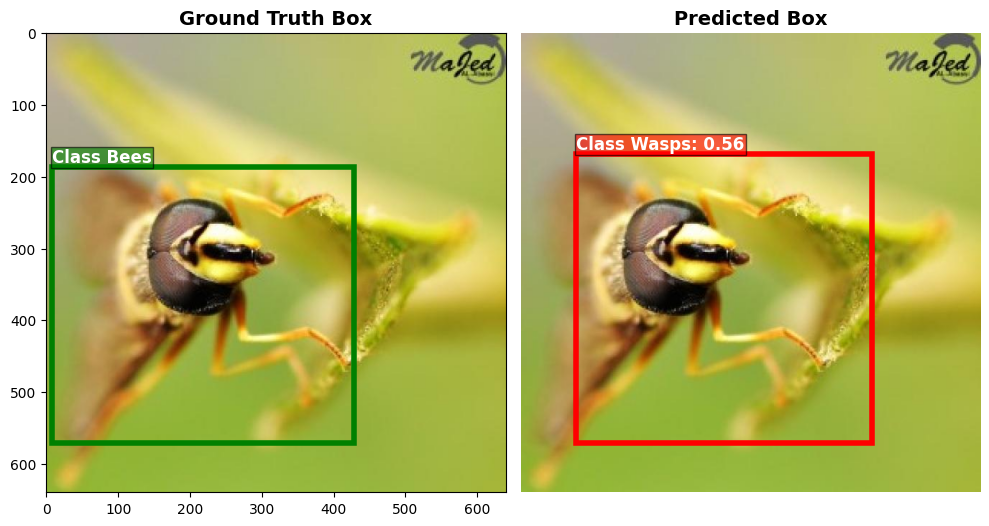

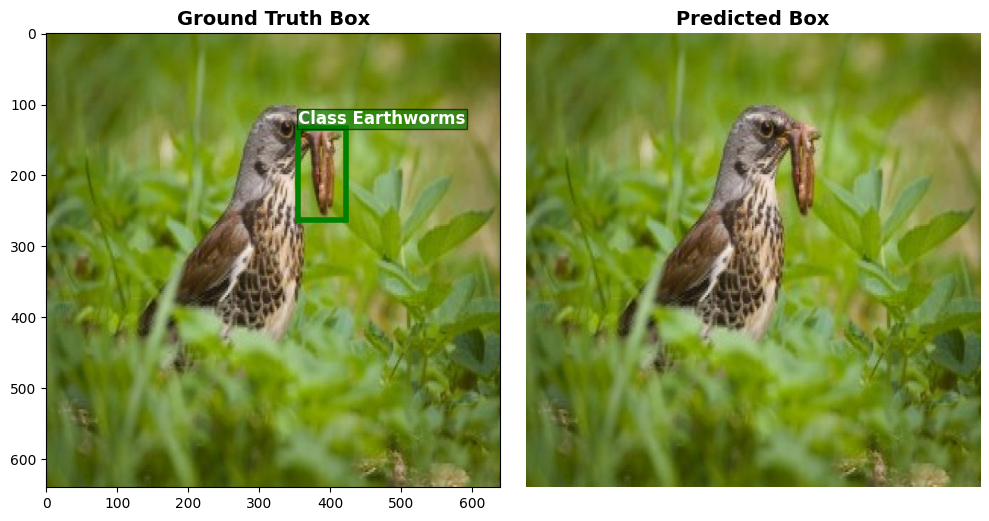

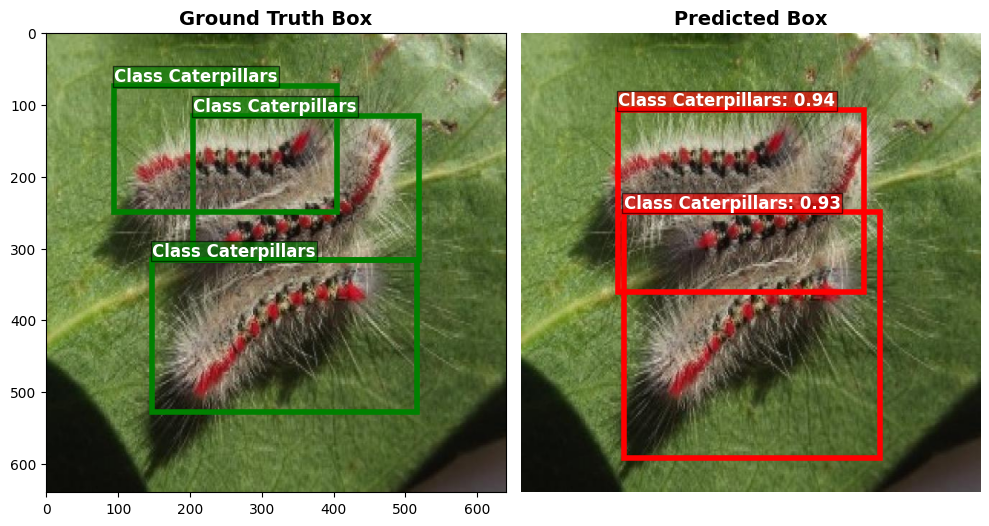

In [88]:
def visualise_predictions(model, device, dataset, num_images=20, confidence=0.5):
  model.eval()
  samples = random.sample(range(len(dataset)), num_images)

  with torch.no_grad():
    for sample in samples:
      image, target = dataset[sample]
      prediction = model([image.to(device)])[0]

      prediction = {k: v.to('cpu') for k, v in prediction.items()}
      target = {k: v.to('cpu') for k, v in target.items()}

      pred_labels = prediction["labels"][prediction["scores"] >= confidence].numpy()
      pred_boxes = prediction["boxes"][prediction["scores"] >= confidence].numpy()
      pred_scores = prediction["scores"][prediction["scores"] >= confidence].numpy()

      # Will need to convert the image tensor to the correct configuration
      # then convert it to numpy for matplotlib to display it.
      numpy_image = image.permute(1, 2, 0).cpu().numpy()
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

      # Show the ground truth boxes in one axis
      ax1.imshow(numpy_image)
      ax1.set_title("Ground Truth Box", weight='bold', fontsize=14)
      for label, box in zip(target["labels"], target["boxes"]):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=4, edgecolor='green', facecolor='none'
        )
        ax1.add_patch(rect)
        ax1.text(x_min, y_min - 6, f"Class {classnames[label.item() - 1]}",
                            color="white", fontsize=12, weight="bold",
                            bbox=dict(facecolor='green', alpha=0.6, pad=1))
      plt.axis('off')

      # Show the predicted boxes and the scores in the other axis
      ax2.imshow(numpy_image)
      ax2.set_title("Predicted Box", weight='bold', fontsize=14)
      for label, box, score in zip(pred_labels, pred_boxes, pred_scores):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=4, edgecolor='red', facecolor='none'
        )
        ax2.add_patch(rect)
        ax2.text(x_min, y_min - 6, f"Class {classnames[label.item() - 1]}: {score:.2f}",
                            color="white", fontsize=12, weight="bold",
                            bbox=dict(facecolor='red', alpha=0.6, pad=1))
      plt.axis('off')

      plt.tight_layout()
      plt.show()

visualise_predictions(model, device, test_dataset, num_images=3)






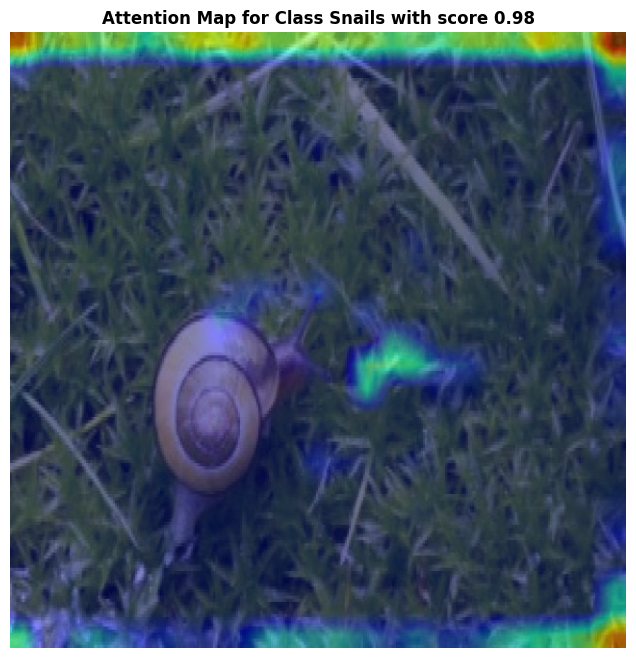

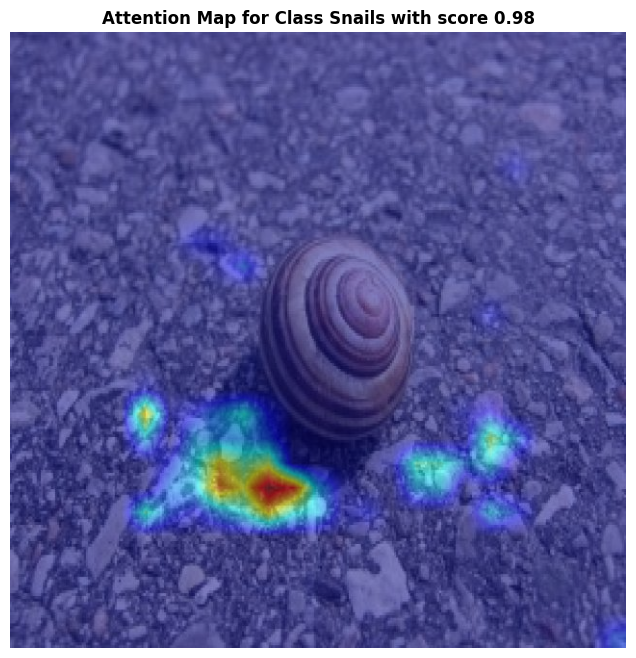

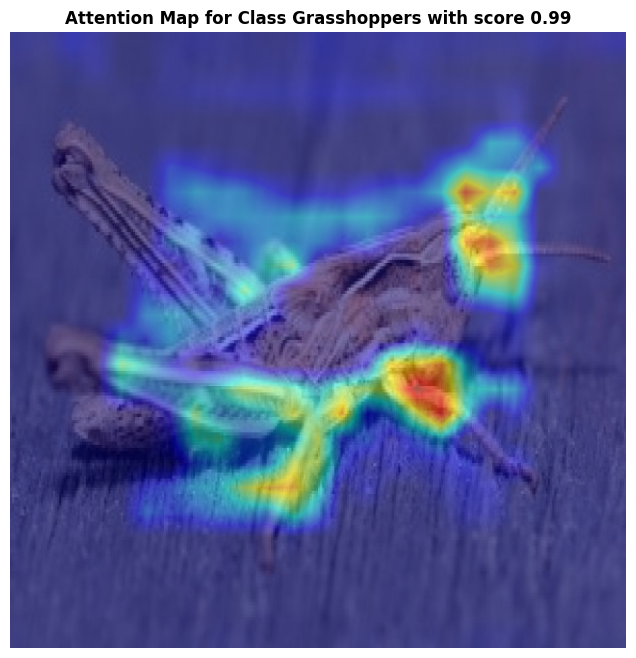

In [90]:
def visualise_attention_maps(model, device, dataset, confidence=0.5, num_images=10):
  """The following helper method will use the python-grad-cam library to help us generate attention maps
  for our modified faster R-CNN model to better understand what parts of the image the model is seeing when making the
  prediction. This is very helpful for Explainable AI (XAI)."""
  # Use the last layer of the resnet backbone is the best layer for XAI
  # or we can use all layers and grad-cam will average it out
  target_layers = [model.backbone.body.layer4[-1]]

  model.eval()

  samples = random.sample(range(len(dataset)), num_images)
  for sample in samples:
    image, target = dataset[sample]

    predictions = model([image.to(device)])[0]
    predictions = {k: v.to('cpu') for k, v in predictions.items()}
    if sum(predictions["scores"] >= confidence) == 0:
      print("No confident predictions.")
      continue

    # Will need to add another dimension to our image tensor
    # since grad-cam needs 4 dimensions within the input as opposed
    # to the 3 we get from our dataset
    input_tensor = image.unsqueeze(0).to(device)

    labels = predictions["labels"][predictions["scores"] >= confidence].cpu()
    boxes = predictions["boxes"][predictions["scores"] >= confidence].cpu()
    scores = predictions["scores"][predictions["scores"] >= confidence].cpu()

    # Convert image dimensions to matplotlibs format and
    # normalise image pixels between 0 and 1 or else we
    # get an error
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = np.clip(image_np, 0, 1)

    # Using Grad-CAM API docs for this https://jacobgil.github.io/pytorch-gradcam-book/introduction.html
    cam = GradCAM(model=model, target_layers=target_layers)

    # Go through each predicted box and create a
    # heatmap of what the model is paying attention to
    for box in range(len(boxes)):
      targets = [FasterRCNNBoxScoreTarget(labels=[labels[box].item()], bounding_boxes=[boxes[box]])]

      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

      visualisation = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
      plt.figure(figsize=(12, 8))
      plt.title(f"Attention Map for Class {classnames[labels[box].item() - 1]} with score {scores[box]:.2f}", weight='bold', fontsize=12)
      plt.imshow(visualisation)
      plt.axis('off')
      plt.show()


visualise_attention_maps(model, device, test_dataset, confidence=0.5, num_images=3)

## Discussion
After analysing all the results, we can see that the Faster-RCNN model is a great tool to help us tackle the problem in this assignment. It has demonstrated a great ability to detect objects, however the classification of those objects is not as robust as what we got from the YOLO model we also trained. This can be seen by both the numerical results and the plots. 

Training this model was incredibly resource and time intensive as most runs took around 7 hours at least, this is with the pretrained weights from the original COCO dataset. Without the pretrained weights this would easily lead to runtimes of 20+ hours and much worse results, which just didn't seem realistic for this assignment. 

Overall, with the advanced improvements I made on top of the pytorch model, I think I would have like to use the v2 version of this model in the future. I did attempt to use it since it was taking too much time to train so I resorted with the original version of the model. This is just a short discussion, I have gone into more detail in the actual report :)